(2750, 4000, 3)


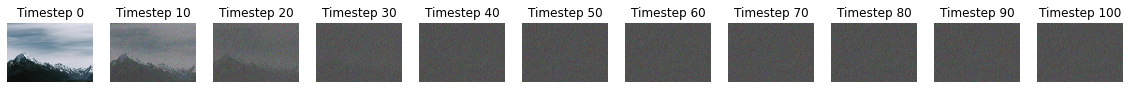

In [11]:
from PIL import Image
import numpy as np
import torch
import matplotlib.pyplot as plt

# Define parameters
beta1 = 0.01  # Example value for beta1
beta2 = 0.99  # Example value for beta2
timesteps = 100  # Number of timesteps

# Construct b_t, a_t, and ab_t
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

b_t = (beta2 - beta1) * torch.linspace(0, 1, timesteps + 1, device=device) + beta1
a_t = 1 - b_t
ab_t = torch.cumsum(a_t.log(), dim=0).exp().to(device)  # Move ab_t to the same device
ab_t[0] = 1.0  # Ensure the initial value is 1.0 (100% of the original image)

# Function to perturb an image to a specified noise level
def perturb_input(x, t, noise):
    return ab_t.sqrt()[t, None, None, None] * x + (1 - ab_t[t, None, None, None]).sqrt() * noise

# Function to normalize and convert numpy array to PyTorch tensor
def normalize_and_convert(img_array):
    img_array = img_array / 255.0  # Normalize to [0, 1]
    img_tensor = torch.tensor(img_array, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)  # Convert to tensor and add batch dimension, move to device
    return img_tensor

# Function to convert image to numpy array
def image_to_numpy(image_path):
    # Open the image file
    img = Image.open(image_path)
    
    # Ensure the image is in RGB mode
    img = img.convert('RGB')
    
    # Convert image to numpy array
    img_array = np.array(img)
    
    return img_array

# Function to visualize the perturbation process
def gaussian_visualizer(img_array, timesteps):
    img_tensor = normalize_and_convert(img_array)
    noise = torch.randn_like(img_tensor, device=device)
    
    fig, axes = plt.subplots(1, timesteps // 10 + 1, figsize=(20, 4))
    for i, ax in enumerate(axes):
        t = i * 10  # Visualizing at intervals of 10 timesteps
        perturbed_image = perturb_input(img_tensor, t, noise)
        perturbed_image = perturbed_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert back to HWC format for visualization
        ax.imshow(np.clip(perturbed_image, 0, 1))  # Ensure values are in [0, 1]
        ax.set_title(f"Timestep {t}")
        ax.axis('off')
    plt.show()

# Example usage
image_path = 'pexels-lastly-772803.jpg'  # Replace with your image path
img_array = image_to_numpy(image_path)
print(img_array.shape)  # Should be (height, width, 3)

gaussian_visualizer(img_array, timesteps)


In [12]:
import os

# Updated function to save the perturbed image at timestep 100
def save_perturbed_image(img_array, timestep, output_path):
    img_tensor = normalize_and_convert(img_array)
    noise = torch.randn_like(img_tensor, device=device)
    
    perturbed_image = perturb_input(img_tensor, timestep, noise)
    perturbed_image = perturbed_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert back to HWC format for saving
    perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure values are in [0, 1]
    
    # Convert to PIL Image
    perturbed_image_pil = Image.fromarray((perturbed_image * 255).astype(np.uint8))
    
    # Save the image
    perturbed_image_pil.save(output_path)

# Example usage to save the perturbed image at timestep 100
image_path = 'pexels-lastly-772803.jpg'  # Replace with your image path
img_array = image_to_numpy(image_path)

output_path = 'perturbed_image_timestep_100.jpg'  # Replace with your desired output path

save_perturbed_image(img_array, 100, output_path)


In [13]:
import os
import random

# Function to decode the perturbed image
def decode_perturbed_image(img_array, timestep, noise_levels):
    img_tensor = normalize_and_convert(img_array)
    
    decoded_images = []
    
    for noise_level in noise_levels:
        noise = torch.randn_like(img_tensor, device=device) * noise_level
        
        perturbed_image = perturb_input(img_tensor, timestep, noise)
        perturbed_image = perturbed_image.squeeze().permute(1, 2, 0).cpu().numpy()  # Convert back to HWC format for saving
        perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure values are in [0, 1]
        
        decoded_images.append(perturbed_image)
    
    return decoded_images

# Example usage to save the perturbed image at timestep 100
image_path = 'pexels-lastly-772803.jpg'  # Replace with your image path
img_array = image_to_numpy(image_path)

timestep = 100
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]  # Example noise levels

# Save the perturbed image at timestep 100
output_path = 'perturbed_image_timestep_100.jpg'  # Replace with your desired output path
save_perturbed_image(img_array, timestep, output_path)

# Decode the perturbed image for different noise levels
decoded_images = decode_perturbed_image(img_array, timestep, noise_levels)

# Display or save decoded images (example showing)
for i, decoded_image in enumerate(decoded_images):
    decoded_image_pil = Image.fromarray((decoded_image * 255).astype(np.uint8))
    decoded_image_pil.save(f'decoded_image_{i}_noise_{noise_levels[i]}.jpg')


In [2]:
import os
import random

# Function to decode the perturbed image
def decode_perturbed_image(img_array, timestep, noise_levels):
    img_tensor = normalize_and_convert(img_array)
    
    decoded_images = []
    
    # Decode with the original noise level used during encoding
    original_noise = torch.randn_like(img_tensor, device=device) * (1 - ab_t[timestep])
    perturbed_image = perturb_input(img_tensor, timestep, original_noise)
    perturbed_image = perturbed_image.squeeze().permute(1, 2, 0).cpu().numpy()
    decoded_images.append(np.clip(perturbed_image, 0, 1))
    
    # Decode with different noise levels
    for noise_level in noise_levels:
        noise = torch.randn_like(img_tensor, device=device) * noise_level
        perturbed_image = perturb_input(img_tensor, timestep, noise)
        perturbed_image = perturbed_image.squeeze().permute(1, 2, 0).cpu().numpy()
        decoded_images.append(np.clip(perturbed_image, 0, 1))
    
    return decoded_images

# Example usage to save the perturbed image at timestep 100
image_path = 'pexels-lastly-772803.jpg'  # Replace with your image path
img_array = image_to_numpy(image_path)

timestep = 100
noise_levels = [0.1, 0.2, 0.3, 0.4, 0.5]  # Example noise levels

# Save the perturbed image at timestep 100
output_path = 'perturbed_image_timestep_100.jpg'  # Replace with your desired output path
save_perturbed_image(img_array, timestep, output_path)

# Decode the perturbed image for different noise levels and with original noise
decoded_images = decode_perturbed_image(img_array, timestep, noise_levels)

# Display or save decoded images (example showing)
for i, decoded_image in enumerate(decoded_images):
    if i == 0:
        decoded_image_pil = Image.fromarray((decoded_image * 255).astype(np.uint8))
        decoded_image_pil.save(f'decoded_image_original_noise.jpg')
    else:
        decoded_image_pil = Image.fromarray((decoded_image * 255).astype(np.uint8))
        decoded_image_pil.save(f'decoded_image_{i}_noise_{noise_levels[i-1]}.jpg')


NameError: name 'image_to_numpy' is not defined